In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from a CSV file
#data = pd.read_csv('./data/HR_data.csv', index_col=0)
# Read from zip file
import zipfile
 
# open zipped dataset
with zipfile.ZipFile("data.zip") as z:
   # open the csv file in the dataset
   with z.open("data/HR_data.csv") as f:
       
      # read the dataset
      data = pd.read_csv(f, index_col=0)

/var/folders/bc/ynvgg9rn14v5sl_jcp8x8_s40000gn/T/ipykernel_15128/587024563.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Prepare Data

In [2]:
num_cols = data.columns[:51] 
cat_cols = data.columns[51:]

print(num_cols)
print(cat_cols)

Index(['HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min', 'HR_TD_Max',
       'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew', 'HR_TD_Slope_min',
       'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope', 'TEMP_TD_Mean',
       'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min', 'TEMP_TD_Max',
       'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew', 'TEMP_TD_Slope_min',
       'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean', 'TEMP_TD_Slope',
       'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std', 'EDA_TD_P_Min',
       'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis', 'EDA_TD_P_Skew',
       'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max', 'EDA_TD_P_Slope_mean',
       'EDA_TD_P_Slope', 'EDA_TD_T_Mean', 'EDA_TD_T_Median', 'EDA_TD_T_std',
       'EDA_TD_T_Min', 'EDA_TD_T_Max', 'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew', 'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max',
       'EDA_TD_T_Slope_mean', 'EDA_TD_T_Slope', 'EDA_TD_P_Peaks',
       'EDA_TD_P_RT', 'EDA_TD_P_ReT'],
      dt

In [3]:
from sklearn.preprocessing import LabelEncoder
# Function to convert string columns to numerical
def convert_strings_to_numerical(df):
    label_encoders = {}  # To store label encoder for each string column
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        # Fitting label encoder on the data
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df, label_encoders

# Convert string columns to numerical and get the updated DataFrame
data, encoders = convert_strings_to_numerical(data)

In [4]:
# Standardize
def standardize(X):
    X[num_cols] = (X[num_cols] - X[num_cols].mean()) / X[num_cols].std()
    return X

data = standardize(data)

In [5]:
data[cat_cols].head()

,Round,Phase,Individual,Puzzler,Frustrated,Cohort,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
0,2,2,1,1,2.0,3,1.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0
1,2,1,1,1,3.0,3,2.0,1.0,3.0,2.0,2.0,2.0,3.0,1.0,3.0,3.0
2,2,0,1,1,2.0,3,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
3,1,2,1,1,2.0,3,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
4,1,1,1,1,2.0,3,3.0,1.0,3.0,2.0,3.0,3.0,4.0,2.0,4.0,4.0


## Missing Values analysis
*  few missing values across 5 different observations
* Replace the missing values with the mean of the given feature within the same Cohort, Round and Phase

In [6]:
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data.sort_values(inplace=True)

missing_rows = data.isnull().any(axis=1)
missing_cols = missing_data.index

data[missing_rows][missing_cols]

,EDA_TD_P_RT,EDA_TD_P_ReT,attentive,afraid,active,inspired,determined
104,0.696437,-0.196339,NaN,NaN,NaN,2.0,NaN
120,-0.063669,1.117660,2.0,1.0,2.0,2.0,NaN
122,2.994075,0.573621,3.0,1.0,2.0,NaN,3.0
125,0.237947,-0.165677,3.0,4.0,2.0,NaN,2.0
272,NaN,NaN,3.0,1.0,3.0,2.0,3.0


In [7]:
# Calculate mean of the column within the same Round, Phase, Puzzler and Cohort
means_for_missing = data.groupby(['Round', 'Phase', 'Puzzler', 'Cohort']).mean().reset_index()

# Replace missing values
for index, row in data.iterrows():
    if row.isnull().any():
        mean_row = means_for_missing[(means_for_missing['Round'] == row['Round']) 
                                     & (means_for_missing['Phase'] == row['Phase']) 
                                     & (means_for_missing['Puzzler'] == row['Puzzler']) 
                                     & (means_for_missing['Cohort'] == row['Cohort'])]
        
        # only replace the values that are missing
        for col in row[row.isnull()].index:
            # round the questionnaire values
            if col in ['attentive', 'afraid', 'active', 'inspired', 'determined']:
                data.at[index, col] = np.round(mean_row[col].values[0])
            else:
                data.at[index, col] = mean_row[col].values[0]

# Check that it works as expected
data[missing_rows][missing_cols]

,EDA_TD_P_RT,EDA_TD_P_ReT,attentive,afraid,active,inspired,determined
104,0.696437,-0.196339,3.0,1.0,2.0,2.0,3.0
120,-0.063669,1.117660,2.0,1.0,2.0,2.0,2.0
122,2.994075,0.573621,3.0,1.0,2.0,2.0,3.0
125,0.237947,-0.165677,3.0,4.0,2.0,2.0,2.0
272,1.205642,0.640830,3.0,1.0,3.0,2.0,3.0


In [8]:
data.head()

,HR_TD_Mean,HR_TD_Median,HR_TD_std,HR_TD_Min,HR_TD_Max,HR_TD_AUC,HR_TD_Kurtosis,HR_TD_Skew,HR_TD_Slope_min,HR_TD_Slope_max,...,upset,hostile,alert,ashamed,inspired,nervous,attentive,afraid,active,determined
0,0.010007,-0.062252,0.186914,-0.163617,0.001626,-0.312025,-0.620396,-0.007311,-0.414192,0.976552,...,1.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,2.0
1,-0.176517,-0.069694,-0.792361,0.111511,-0.569893,-0.086150,-0.114098,-0.045208,0.531521,-0.698825,...,2.0,1.0,3.0,2.0,2.0,2.0,3.0,1.0,3.0,3.0
2,-0.033069,0.038626,-0.773057,0.368440,-0.543429,-0.987033,-0.335849,-0.739221,-0.158594,-0.342475,...,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
3,0.397420,0.531440,0.163620,0.068689,0.206585,0.152837,-0.485856,-0.512212,0.263143,0.279808,...,1.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,3.0,3.0
4,-0.550724,-0.375636,-0.670533,-0.409841,-0.702215,-0.311121,0.152625,-1.137219,0.499571,-0.385024,...,3.0,1.0,3.0,2.0,3.0,3.0,4.0,2.0,4.0,4.0


## Feature Selection
* greedy algortihm based on Silhouette Score following this article: https://medium.com/analytics-vidhya/k-means-algorithm-in-4-parts-4-4-42bc6c781e46

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from itertools import combinations

maxvars = 30
kmin = 2
kmax = 8
selected_variables = []
best_ks = {}

data_num = data[num_cols]

# List of all variables/features
all_variables = data_num.columns.tolist()

def get_silhouette_score(features, kmin, kmax):
    best_score = -1
    best_k = kmin
    
    for k in range(kmin, kmax + 1):
        kmeans = KMeans(n_clusters=k)
        cluster_labels = kmeans.fit_predict(data_num[features])
        silhouette_avg = silhouette_score(data_num[features], cluster_labels)
        
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_k = k
    
    return best_score, best_k

# Loop until the number of selected variables reaches maxvars
while len(selected_variables) < maxvars and len(all_variables) > 0:
    best_variable = None
    best_score = -1
    best_k = kmin
    
    # Loop over remaining variables
    for variable in all_variables:
        # Combine selected variables with current variable
        test_features = selected_variables + [variable]
        
        # Get silhouette score and best k
        score, k = get_silhouette_score(test_features, kmin, kmax)
        
        # Update best score, best k, and best variable
        if score > best_score:
            best_score = score
            best_k = k
            best_variable = variable
    
    # Add best variable and best k to selected variables and best_ks
    selected_variables.append(best_variable)
    best_ks[best_variable] = best_k
    all_variables.remove(best_variable)
    
    print(f"Selected variable: {best_variable}, Silhouette Score: {best_score}, Best k: {best_k}")

print(f"Selected variables: {selected_variables}")
print(f"Best k values: {best_ks}")


Selected variable: EDA_TD_P_Min, Silhouette Score: 0.9654029024723781, Best k: 2
Selected variable: EDA_TD_P_Median, Silhouette Score: 0.9372068857787056, Best k: 2
Selected variable: EDA_TD_P_ReT, Silhouette Score: 0.8890175863168901, Best k: 2
Selected variable: EDA_TD_T_Slope_max, Silhouette Score: 0.8705363695355937, Best k: 2
Selected variable: EDA_TD_P_Slope_mean, Silhouette Score: 0.85797889548804, Best k: 2
Selected variable: EDA_TD_P_std, Silhouette Score: 0.8464373886835116, Best k: 2
Selected variable: EDA_TD_T_AUC, Silhouette Score: 0.8297174421412742, Best k: 2
Selected variable: EDA_TD_P_AUC, Silhouette Score: 0.7531305112494783, Best k: 2
Selected variable: EDA_TD_P_Slope, Silhouette Score: 0.7616439421758425, Best k: 2
Selected variable: EDA_TD_P_Mean, Silhouette Score: 0.773754846402353, Best k: 2
Selected variable: EDA_TD_P_Max, Silhouette Score: 0.7707634607689076, Best k: 2
Selected variable: EDA_TD_T_std, Silhouette Score: 0.7675464855713773, Best k: 2
Selected var

In [32]:
correlation_matrix = data_num.corr().abs()

# Select upper triangle of correlation matrix
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

data_filtered = data_num.drop(columns=to_drop)
print(data_filtered.columns)
print(len(data_filtered.columns))

Index(['HR_TD_Mean', 'HR_TD_std', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean',
       'TEMP_TD_Mean', 'TEMP_TD_std', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis',
       'TEMP_TD_Skew', 'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max',
       'TEMP_TD_Slope_mean', 'EDA_TD_P_Mean', 'EDA_TD_P_Min',
       'EDA_TD_P_Kurtosis', 'EDA_TD_T_Mean', 'EDA_TD_T_Kurtosis',
       'EDA_TD_T_Skew', 'EDA_TD_T_Slope_mean', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT',
       'EDA_TD_P_ReT'],
      dtype='object')
25


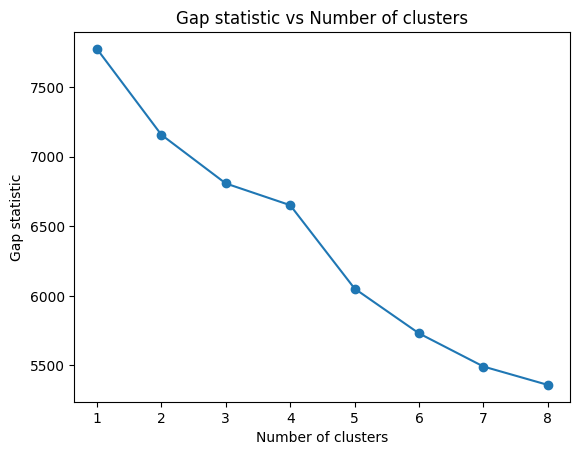

In [33]:
# Choose the best k using the Gap Statistic
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

def calculate_gap(data, k_max):
    gaps = []
    for k in range(1, k_max + 1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        gap = kmeans.inertia_
        gaps.append(gap)
    return gaps

gaps = calculate_gap(data_filtered, 8)

plt.plot(range(1, 9), gaps, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Gap statistic')
plt.title('Gap statistic vs Number of clusters')

plt.show()
